In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

/home/asuran/anaconda3/envs/imdb_nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the Stanford IMDb dataset without the unsupervised split
imdb_dataset = load_dataset('stanfordnlp/imdb', split={'train': 'train', 'test': 'test'})

In [3]:
train_data = imdb_dataset['train'].to_pandas()
test_data = imdb_dataset['test'].to_pandas()

In [4]:
print(train_data.head())


                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


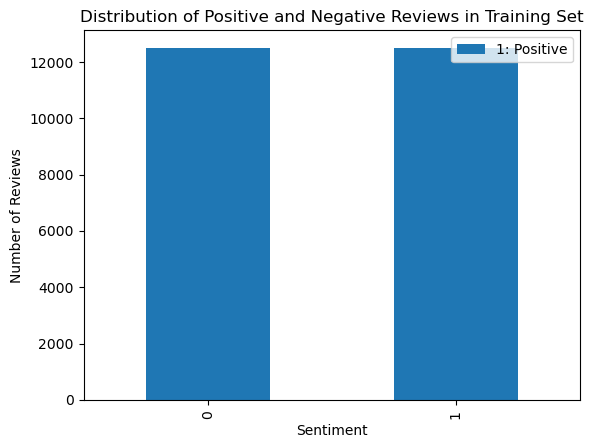

In [5]:
train_data['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Positive and Negative Reviews in Training Set')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.legend(['1: Positive', '0: Negative'], loc='upper right')
plt.show()



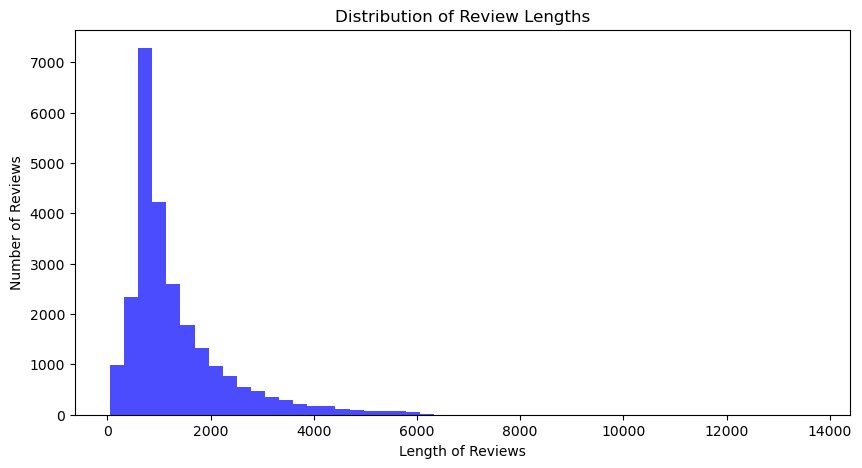

In [6]:
# Calculate the length of reviews
train_data['review_length'] = train_data['text'].apply(len)

# Plot the distribution of review lengths
plt.figure(figsize=(10, 5))
plt.hist(train_data['review_length'], bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Reviews')
plt.ylabel('Number of Reviews')
plt.show()


For the baseline model, starting with a simple Logistic Regression classifier,using TF-IDF (Term Frequency-Inverse Document Frequency)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_features=10000)
X_train = vectorizer_tfidf.fit_transform(train_data['text'])
y_train = train_data['label']
X_test = vectorizer_tfidf.transform(test_data['text'])
y_test = test_data['label']


train a simple logistic regression model

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

lr_model_tdf = LogisticRegression()
lr_model_tdf.fit(X_train, y_train)

train_predictions = lr_model_tdf.predict(X_train)
test_predictions = lr_model_tdf.predict(X_test)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

# Evaluate on the test set
X_test = vectorizer_tfidf.transform(test_data['text'])
y_test = test_data['label']


print("Logistic Regression Model Accuracy on Training Set_ TF-IDF:", train_accuracy)
print("Logistic Regression Model Accuracy on Test Set_ TF-IDF:", test_accuracy)
print(classification_report(y_test, test_predictions))


Logistic Regression Model Accuracy on Training Set_ TF-IDF: 0.92592
Logistic Regression Model Accuracy on Test Set_ TF-IDF: 0.8792
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



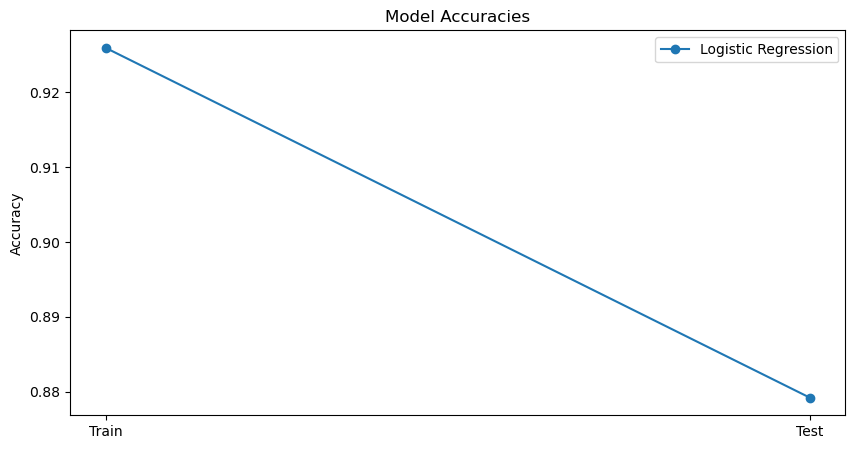

In [10]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(['Train', 'Test'], [train_accuracy, test_accuracy], label='Logistic Regression', marker='o')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.legend()
plt.show()

In [11]:
from joblib import dump

dump(lr_model_tdf, 'lr_model_tfidf.joblib')
dump(vectorizer_tfidf, 'tfidf_vectorizer.joblib')


['tfidf_vectorizer.joblib']

LR model with Bag of Words method

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_bow = CountVectorizer(stop_words='english', max_features=10000)
X_train_bow = vectorizer_bow.fit_transform(train_data['text'])
X_test_bow = vectorizer_bow.transform(test_data['text'])


In [13]:
lr_model_bow = LogisticRegression(max_iter=1000)
lr_model_bow.fit(X_train_bow, y_train)

# Predictions
train_predictions = lr_model_bow.predict(X_train_bow)
test_predictions = lr_model_bow.predict(X_test_bow)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print("Accuracy on Training Set_bow:", train_accuracy)
print("Accuracy on Test Set_bow:", test_accuracy)
print(classification_report(y_test, test_predictions))

Accuracy on Training Set_bow: 0.9904
Accuracy on Test Set_bow: 0.84788
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     12500
           1       0.86      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



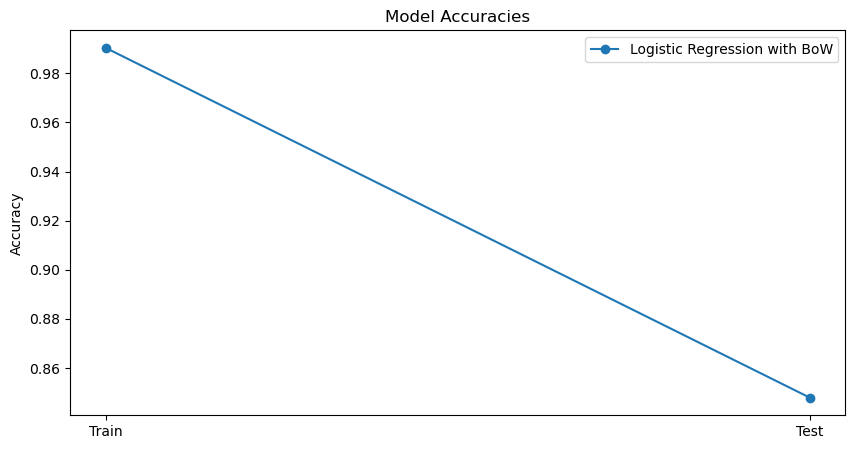

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(['Train', 'Test'], [train_accuracy, test_accuracy], label='Logistic Regression with BoW', marker='o')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.legend()
plt.show()


In [15]:
dump(lr_model_bow, 'lr_model_bow.joblib')
dump(vectorizer_bow, 'lr_vectorizer_bow.joblib')


['lr_vectorizer_bow.joblib']

In [16]:
import gensim
from gensim.models import KeyedVectors

In [21]:
# Load pre-trained Word2Vec model
model_path = 'GoogleNews-vectors-negative300.bin'
word_vectors = KeyedVectors.load_word2vec_format(model_path, binary=True)



In [25]:
from gensim.models import Word2Vec

# Tokenize the text
train_tokens = [text.split() for text in train_data['text']]
test_tokens = [text.split() for text in test_data['text']]

# Train a Word2Vec model
w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=5, workers=4)



In [26]:
w2v_model.save("custom_word2vec.model")

In [27]:
import numpy as np

def document_vector(word_model, doc):
    # Remove out-of-vocabulary words and get vectors for words in the document
    doc = [word for word in doc if word in word_model.wv.key_to_index]
    return np.mean(word_model.wv[doc], axis=0) if doc else np.zeros(word_model.vector_size)

X_train = np.array([document_vector(w2v_model, doc) for doc in train_tokens])
X_test = np.array([document_vector(w2v_model, doc) for doc in test_tokens])

In [28]:
y_train = train_data['label'].values
y_test = test_data['label'].values

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Train the logistic regression model
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predict and evaluate the model
predictions = classifier.predict(X_test)
print("Accuracy on Training Word2Vec:", train_accuracy)
print("Accuracy on Test Set Word2Vec:", test_accuracy)
print(classification_report(y_test, test_predictions))


Accuracy on Training Word2Vec: 0.9904
Accuracy on Test Set Word2Vec: 0.84788
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     12500
           1       0.86      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



In [31]:
dump(classifier, 'lr_model_Word2Vec.joblib')

['lr_model_Word2Vec.joblib']